# Literature

## 1. Motivation

### 1.1 Why we chose this topic
The reason humans are the dominant species on this planet and have made progress exponentially over years  can be attributed to transfer of information over generations orally(initially) and then after the invention of writing, through the written form. This makes writers essential to the fabric of human existence.

So we wanted to go on a journey to explore the personalities of the writers in order to explore their impact on the universal consciousness of humanity. These writers are reflections of the human civilzation and we want to have a taste of it through network theory 

### 1.2 Project goals
The world of writers is huge with endless possibilities and its easy to get lost which we found out as well on this journey we undertook. The number of writers are immense and so is the ways they can be connected.
Initillay we decided to focus on the noble laureats, but later decided to expand our search with writers from these four genres- Playwright, Poet, Fantasy and Historical Novelist. We then decided to explore these 4 categories in following steps:

1- Build a network of these writers and explore different attributes of this network.

2- Create world clouds individually for these 4 genres using TF and TF-IDF.

3- Find communites in the network. 

4- Finding top words in these communities.

5- Sentiment Analysis for all writers seperately using LabMT and VADER.

6- Sentiment Analysis for the communities.




In [2]:
!pip install networkx
!pip install powerlaw
!pip install fa2
!pip install community
!pip install vaderSentiment
!pip install wordcloud==1.8.1
!pip install python-louvain

     |████████████████████████████████| 1.9 MB 19.2 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 435 kB 12.2 MB/s 
  Created wheel for fa2: filename=fa2-0.3.5-cp37-cp37m-linux_x86_64.whl size=151468 sha256=21b69f7a2275c5474abb567598a44e12ea5f94ec3096731ad5d0043ffa73ff14
  Stored in directory: /root/.cache/pip/wheels/d3/b5/0a/df14cac170d872be0dd0300309b7463b5e52d936c3edce7963
Successfully built fa2
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 95 kB 6.8 MB/s 
  Created wheel for community: filename=community-1.0.0b1-py3-none-any.whl size=2152 sha256=38f221702e71e557cda27d0146ac2742e029a1c42e9247d0c2fcce282c2f3843
  Stored in directory: /root/.cache/pip/wheels/d9/cf/a6/01e9b603fca646a52b27e42d5c561

In [3]:
# --- Imports ---
import urllib.request
import json, re, nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import collections
from pathlib import Path
import os
import powerlaw
from fa2 import ForceAtlas2
from nltk import FreqDist
import math
from wordcloud import WordCloud
from collections import defaultdict
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from community import community_louvain
import matplotlib.cm as cm

In [4]:
# comment out if nltk already downloaded

nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------

Download which package (l=list; x=cancel)?
       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package brown to /root/nltk_data...
       |   Unzipping corpora/brown.zip.
       | Downloading package brown_tei to /root/nltk_data...
       |   Unzipping corpora/brown_tei.zip.
       | Downloading package cess_cat to /root/nltk_data...
       |   Unzipping corpora/cess_cat.zip.
       | Downloading package cess_esp to /root/nltk_data...
       |   Unzipping corpora/cess

True

In [5]:
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize

### Downloading list of writers from the mentioned categories and all literary awards

In [7]:
#using wiki api to download relevant pages- List of playwrights,List of fantasy_authors,List of poets,"List_of_historical_novelists", "List_of_literary_awards" 

baseurl="https://en.wikipedia.org/w/api.php?"
action="action=query"
halftitle="titles="
content= "prop=revisions&rvprop=content"
dataformat= "format=json"
redirect= "redirect=yes"

titles=["List_of_playwrights","List_of_fantasy_authors","List_of_poets", "List_of_historical_novelists", "List_of_literary_awards" ]
queries=["{}{}&{}&{}&{}{}".format(baseurl,dataformat,action,content,halftitle,x,) for x  in titles]
wikiresponses = [ urllib.request.urlopen(x)  for x in queries]
wikidatas= [x.read() for x  in wikiresponses]
wikitextpages=[x.decode('utf-8') for x in wikidatas]
wikijsons= [json.loads(x)  for x in wikitextpages]

In [8]:
Infobox = [ (list(x.get("query").get('pages').values())[0].get("revisions"))[-1].get('*')  for x in wikijsons]

# filtering writers names and award names respectively

match_authors_playwrights= re.findall(r'\*\[\[(.*?)(?:\|.*)?\]\]', Infobox[0].split('==See also==')[0])
match_authors_fantasy= re.findall(r'\*(?:[  ])*\[\[(.*?)(?:\|.*)?\]\]', Infobox[1].split('==See also==')[0])
match_authors_poets= re.findall(r'\*\[\[(.*?)(?:\|.*)?\]\]', Infobox[2].split('==See also==')[0])
match_authors_historical_novelist= re.findall(r'\*\[\[(.*?)(?:\|.*)?\]\]', Infobox[3].split('==See also==')[0])
match_all_awards= re.findall(r'\*(?:[ ])*\[\[(.*?)(?:[\||\#].*)?\]\]', Infobox[4].split('==See also==')[0])


# adding writers and their genre to the dataframe

df_authors_fantasy= pd.DataFrame({ 'genre' : "Fantasy", 'Name':match_authors_fantasy}) 
df_authors_poets= pd.DataFrame({ 'genre' : "Poet", 'Name':match_authors_poets}) 
df_authors_historical_novelist= pd.DataFrame({ 'genre' : "Historical Novelist", 'Name':match_authors_historical_novelist})
df_authors= pd.DataFrame({ 'genre' : "Playwright", 'Name':match_authors_playwrights}) 
df_authors=df_authors.append(df_authors_fantasy, ignore_index= True)
df_authors=df_authors.append(df_authors_poets, ignore_index= True)
df_authors=df_authors.append(df_authors_historical_novelist, ignore_index= True)
df_authors.drop_duplicates(subset ="Name",keep = 'last', inplace = True)
df_authors = df_authors.reset_index(drop=True)


In [9]:
#Cleaning up award names further by removing double names and certain unnecessary addon strings.

new_all_awards_list=[]
search_aw_text=""
for i,aw in enumerate(match_all_awards):
    match_all_awards[i] = aw.replace(":es","").replace(":hr","").replace(":pt","").split('(')[0].strip()
    search_aw_text= search_aw_text+ match_all_awards[i]


print("Total number of different literary awards possible are:", len(match_all_awards))

Total number of different literary awards possible are: 680


### Downloading the individual writer's pages

In [10]:
## --- (Uncomment in case you want to run it yourself, it takes a while...) ---
from pathlib import Path
import os

authors_titles=[ re.sub(" ", "_", x) for x in df_authors.Name]
no_exist_wikipage_index = []
Laureats_wiki_strings=[]
c=0

for i, x in enumerate(authors_titles):

    wikistring= "#REDIRECT" + "[[" + x + "]]"
    while((wikistring.startswith("#REDIRECT"))|(wikistring.startswith("#Redirect"))|(wikistring.startswith("#redirect"))):

        page_name= re.findall(r"\[\[(.*)\]\]", wikistring)
        page_name_url= urllib.parse.quote(re.sub(" ", "_", page_name[0]))
        query_page=  "{}{}&{}&{}&{}{}".format(baseurl,dataformat,action,content,halftitle,page_name_url)
        wikiresponse= urllib.request.urlopen(query_page)
        wikidatas= wikiresponse.read()
        wikitextpage= wikidatas.decode('utf-8')
        wikijsons= json.loads(wikitextpage)
        t= list(wikijsons.get("query").get('pages').values())[0].get("revisions")
        if t is None:
            wikistring=""
            no_exist_wikipage_index.append(i)
            c=c+1
        else:
            wikistring= t[-1].get("*")
            filename= "Authors/"+ authors_titles[i].split("/")[0] +".txt"
            with open((os.path.expanduser(filename)), 'w') as f:
                f.write(wikistring)
    
df_authors.drop(index=no_exist_wikipage_index, inplace=True)
df_authors=df_authors.reset_index(drop=True);

print("Wiki pages not found number:", c)

#notdownloaded 1353,2947,4350


### Reading the individual pages for the list of writers

In [11]:
#reading the individual pages of authors 

authors_titles=[ re.sub(" ", "_", x) for x in df_authors.Name]
no_exist_wikipage_index = []
Laureats_wiki_strings=[]

# removing names in dataframe for pages not found

no_exist_wikipage_index = [1353,2947,4350] # pages not found when downloading. Can be commented out if you chose to download the pages yourself
df_authors.drop(index=no_exist_wikipage_index, inplace=True)
df_authors=df_authors.reset_index(drop=True);


#opening files and reading pages

authors_titles=[ re.sub(" ", "_", x) for x in df_authors.Name]
author_pages_description=[]

for i in range(len(authors_titles)):
    filename= "./Authors/"+ authors_titles[i].split("/")[0] +".txt"
    with open((os.path.expanduser(filename)), 'r') as f:
        author_pages_description.append(f.read())

In [12]:
#Finding birth place, death place ,birth year, death year, awards and nationality of authors

birth_place= 'birth_place(?:[  \=])*(.*)'
death_place= 'death_place(?:[  \=])*(.*)'
birth_year= 'birth_date(?:[  \=])*(?:.+?)([0-9]{4})'
death_year= 'death_date(?:[  \=])*(?:.+?)([0-9]{4})'
awards=  'awards(?:[  \=])*(.*)'
nationality = 'nationality(?:[  \=])*(.*)'
occupation= 'occupation(?:[  \=])*(.*)'
spouse= 'spouse(?:[  \=])*(.*)'


match_birth_place= [re.findall(birth_place, x) for x in author_pages_description]
match_death_place= [re.findall(death_place, x) for x in author_pages_description]
match_birth_year= [re.findall(birth_year, x) for x in author_pages_description]
match_death_year = [re.findall(death_year, x) for x in author_pages_description]
match_awards= [re.findall(awards, x) for x in author_pages_description]
match_nationality= [re.findall(nationality, x) for x in author_pages_description]
match_occupation= [re.findall(occupation, x) for x in author_pages_description]
match_spouse= [re.findall(spouse, x) for x in author_pages_description]


In [13]:
data_country = pd.read_csv('countries.csv')
Countries_Name = data_country.name
def findCountryName(name):
    for country in Countries_Name:
        if( country in name):
            return (country)

In [14]:
all_birth_place= []
authors_birth_place=[]
for i,cat in enumerate(match_birth_place):
    tc=""
    for j,item in enumerate(cat):
        match_birth_place[i][j]= item.replace("]","").replace("[","").replace("(","").replace(")","").replace("|",",")
        all_birth_place.append(match_birth_place[i][j])
        tc= tc+ match_birth_place[i][j] +" "
    authors_birth_place.append(tc)    

all_death_place= []
authors_death_place=[]
for i,cat in enumerate(match_death_place):
    tc=""
    for j,item in enumerate(cat):
        match_death_place[i][j]= item.replace("]","").replace("[","").replace("(","").replace(")","").replace("|",",")
        all_death_place.append(match_death_place[i][j])
        tc= tc+ match_death_place[i][j] +" "
    authors_death_place.append(tc)    


all_birth_years= []
authors_birth_year= []

for i,cat in enumerate(match_birth_year):
    tc=""
    for j,item in enumerate(cat):
        match_birth_year[i][j]= item.replace("]","").replace("[","").replace("(","").replace(")","").replace("|",",")
        all_birth_years.append(match_birth_year[i][j])
        tc= tc+ match_birth_year[i][j]
    authors_birth_year.append(tc)

all_death_years= []
authors_death_year= []
for i,cat in enumerate(match_death_year):
    tc=""
    for j,item in enumerate(cat):
        match_death_year[i][j]= item.replace("]","").replace("[","").replace("(","").replace(")","").replace("|",",")
        all_death_years.append(match_death_year[i][j])
        tc= tc+ match_death_year[i][j]
    authors_death_year.append(tc)

all_nationality= []
authors_nationality=[]

for i,cat in enumerate(match_nationality):
    tc=""
    for j,item in enumerate(cat):
        match_nationality[i][j]= item.replace("]","").replace("[","").replace("(","").replace(")","").replace("|",",")
        all_nationality.append(match_nationality[i][j])
        tc= tc+ match_nationality[i][j]+" "
    authors_nationality.append(tc)

all_spouse= []
authors_marital_status=[]

for i,cat in enumerate(match_spouse):
    tc="Single"
    for j,item in enumerate(cat):
        match_spouse[i][j]= item.replace("]","").replace("[","").replace("(","").replace(")","").replace("|",",")
        all_spouse.append(match_spouse[i][j])
        if(("Married" in match_spouse[i][j])|("married" in match_spouse[i][j])|("marriage" in match_spouse[i][j])|("Marrage" in match_spouse[i][j])):
            tc="Married"
    authors_marital_status.append(tc)

all_occupation= []
authors_occupation=[]
for i,cat in enumerate(match_occupation):
    tc=""
    for j,item in enumerate(cat):
        match_occupation[i][j]= item.replace("]","").replace("[","").replace("(","").replace(")","").replace("{","").replace(")","").replace("}",",").replace("|","")
        all_occupation.append(match_occupation[i][j])
        tc= tc+ match_occupation[i][j]+" "
    authors_occupation.append(tc)

authors_birth_decade=[]

for i,year in enumerate(authors_birth_year):
    if(year):
        authors_birth_decade.append(year[0:3] +"0")
    else:
        authors_birth_decade.append("")


authors_death_decade=[]

for i,year in enumerate(authors_death_year):
    if(year):
        authors_death_decade.append(year[0:3] +"0")
    else:
        authors_death_decade.append("")


for i,nation in enumerate (authors_nationality):
    if(nation):
        authors_nationality[i]= findCountryName(nation)

for i,nation in enumerate (authors_birth_place):
    if(nation):
        authors_birth_place[i]= findCountryName(nation)

for i,nation in enumerate (authors_death_place):
    if(nation):
        authors_death_place[i]= findCountryName(nation)


df_authors['birth country'] = authors_birth_place
df_authors['death country']= authors_death_place
df_authors['birth decade'] = authors_birth_decade
df_authors['death decade'] = authors_death_decade
df_authors['nationality'] = authors_nationality
df_authors['Marital Status']=authors_marital_status
df_authors['awards']=match_awards
df_authors.to_csv("Authors_Details.csv")


In [ ]:
df_cross = (pd.crosstab(index=df_authors['birth decade'], columns=[df_authors['genre']]).sort_index(axis=1, level=[1, 0]))
df_cross

genre,Fantasy,Historical Novelist,Playwright,Poet
birth decade,,,,
,152,260,469,891
1000,0,0,0,2
1030,0,0,0,1
1040,0,0,0,1
1070,0,0,0,1
...,...,...,...,...
1970,40,16,34,45
1980,22,7,15,11
1990,7,0,0,5


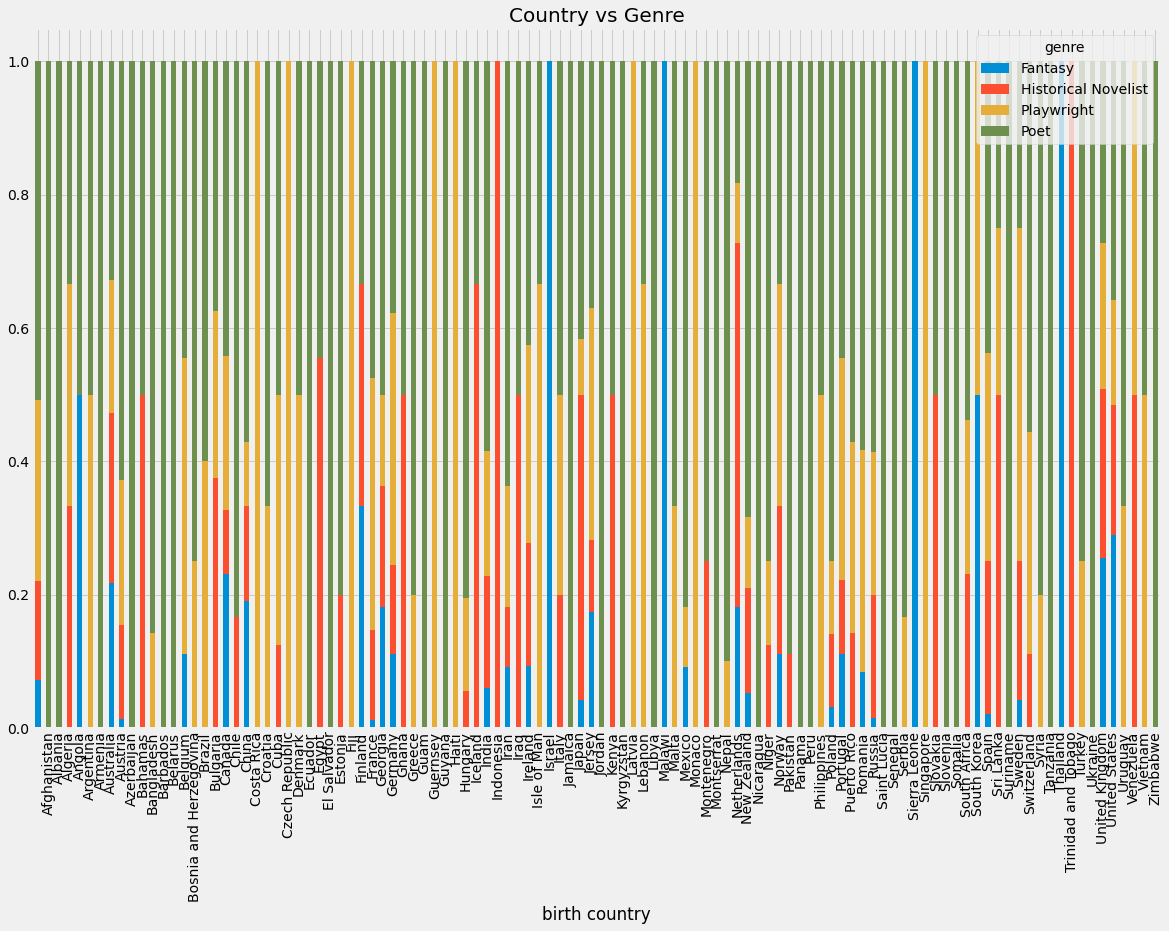

In [ ]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 8)

df_cross = pd.crosstab(df_authors['birth country'], df_authors['genre'])

df_cross.div(df_cross.sum(1).astype(float), axis = 0).plot.bar(stacked = True, figsize = (18, 12))
plt.title('Country vs Genre', fontweight = 30, fontsize = 20)

plt.xticks(rotation = 90)
plt.show()

In [15]:
#matching all links from the writers wiki pages

all_links= '\[\[(.*?)(?:\|.*?)?\]\]'
match_links= [re.findall(all_links, x) for x in author_pages_description]

In [16]:
#Matching award links from all links in the wikipage 
new_author_awards=[]
all_author_awards =[]
for i,cat in enumerate(match_links):
    tc=""
    for j,item in enumerate(cat):
        if(("award" in item)|("Award" in item)):
            item= item.replace("Category:","").replace("File:","").strip() #filitering unnecessary additions to award names

            if(item not in all_author_awards):
                all_author_awards.append(item)
            tc= tc + item +" "
    tc=tc.strip()
    new_author_awards.append(tc)
            

In [17]:
#adding matched text from the matched awards section of wikipage to matched awards links dound in order to create one long string of all awards

authors_awards= []
all_awards= []

for i,cat in enumerate(match_awards):
    tc=""
    for j,item in enumerate(cat):
        match_awards[i][j]= item.replace("]","").replace("[","").replace("(","").replace(")","").replace("|",",").replace("}","").replace("{","")
        match_awards[i][j]=" ".join(match_awards[i][j].split())
        all_awards.append(match_awards[i][j])
        tc= tc+ match_awards[i][j]+" "
    tc= tc.strip()
    new_author_awards[i]= new_author_awards[i] + tc

In [19]:
#Cleaning individual award list

clean_awards=[]
for index,value in enumerate(df_authors.Name):
    clean_awards.append("")

#Finding writer connections who have won the same award 

filtered_award_list=[]
same_awards=[]
for k, aw in enumerate(match_all_awards):
    aw= aw.strip()
    if(aw not in filtered_award_list):
        filtered_award_list.append(aw)
        list_index= [i for i, x in enumerate(new_author_awards) if (aw in x)]
        for i in list_index:
            clean_awards[i]= clean_awards[i] + "\t" + aw 
        same_awards.append(list_index)

df_authors['awards']=clean_awards
df_authors.to_csv("Authors_Details.csv")


### Writers Network(Awards)

Since it was rare to find links of other writers in wikipages of writers, we decided to create a network based on other information such as common birth decades, death decades, nationality, genres, awards etc. We experimented with these networks and eventually decided to go with just the awards network, as it made the most sense intellectually as people winning the same awards are connected to each other through some common physical people networks and represent the same kind of qualities the juries of these awards are looking for, year after year. We chose to connect all individuals who got the same award, assuming the larger the number of famous recipients of a award, the more prestigious the award becomes and the more relevant it is to the writers network.

In [21]:
#Creating the network

authors_titles= df_authors.Name
role= df_authors.genre

DG = nx.Graph()

for i,name in enumerate(authors_titles):
    DG.add_node(name,genre=role[i])

for i, aw in enumerate(filtered_award_list):
    for j, item in enumerate(same_awards[i]):
        if(len(same_awards[i])>(j+1)):
            for k in range(j+1,len(same_awards[i])):
                DG.add_edge(authors_titles[item], authors_titles[same_awards[i][k]], award=aw)

# Discarding isolated nodes
rmNodes = []
for node in DG.nodes:
    print
    if DG.degree(node) == 0:
        rmNodes.append(node)

for node in rmNodes:
    DG.remove_node(node)

### * What is the number of nodes  and links in the network? 

In [ ]:
print(f"Number of nodes: {len(DG.nodes)}")

Number of nodes: 1075


In [ ]:
print(f"Number of links {len(DG.edges)}")

Number of links 41816


### Most awarded writers

In [ ]:
degree_nodes = [(n, d) for n, d in DG.degree()]
degree_nodes = sorted(degree_nodes, key=lambda x: x[1], reverse=True)

print(f"Top 5 awarded authors: {', '.join([item[0] for item in degree_nodes[:5]])}")

Top 5 awarded authors: Ursula K. Le Guin, John Crowley (author), Neil Gaiman, Louise Erdrich, Stephen King


The above result looks quite accurate as these authors are highly revered, famous and have won numerous accolades/awards. 

In [ ]:
highest_degree_Playwright= []
highest_degree_Poet= []
highest_degree_Fantasy= []
highest_degree_Historical_Novelist= []

for (item1, item2 ) in degree_nodes:
    if(DG.nodes[item1]['genre'] == "Playwright"):
        highest_degree_Playwright.append(item1)
for (item1, item2 ) in degree_nodes:
    if(DG.nodes[item1]['genre'] == "Poet"):
        highest_degree_Poet.append(item1)
for (item1, item2 ) in degree_nodes:
    if(DG.nodes[item1]['genre'] == "Fantasy"):
        highest_degree_Fantasy.append(item1)
for (item1, item2 ) in degree_nodes:
    if(DG.nodes[item1]['genre'] == "Historical Novelist"):
        highest_degree_Historical_Novelist.append(item1)

### Most awarded writers from different genres

In [ ]:
print(f"Top awarded playwright: {', '.join([item for item in highest_degree_Playwright[:5]])}")
print(f"Top awarded poet: {', '.join([item for item in highest_degree_Poet[:5]])}")
print(f"Top awarded fantasy writer: {', '.join([item for item in highest_degree_Fantasy[:5]])}")
print(f"Top awarded historical novelist: {', '.join([item for item in highest_degree_Historical_Novelist[:5]])}")

Top awarded playwright: Tony Kushner, Sidney Kingsley, August Wilson, Rob Shearman, Eugene O'Neill
Top awarded poet: Louise Erdrich, Louise Glück, Ruth Stone, John Ashbery, Bob Dylan
Top awarded fantasy writer: Ursula K. Le Guin, John Crowley (author), Neil Gaiman, Stephen King, Manly Wade Wellman
Top awarded historical novelist: Karen Joy Fowler, Toni Morrison, Susanna Clarke, Margaret Mitchell, Thornton Wilder


### Degree distribution

In [ ]:
degree_sequence = sorted([d for n, d in DG.degree()], reverse=True)

def plotDegree(degree_sequence, label=''):
    counter = collections.Counter(degree_sequence)
    x, y = [], []
    for key, value in counter.items():
        x.append(key)
        y.append(value)

    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.title("Degree distributions")
    plt.plot(x, y, 'o', label=label)
    plt.legend(loc="upper right")

def logPlot(degree_sequence):
    counter = collections.Counter(degree_sequence)
    x, y = [], []
    for key, value in counter.items():
        x.append(key)
        y.append(value)

    plt.title('Degree Distribution(Log-Log)')
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.loglog(x, y, 'o')


def histPlot(degree_sequence):
    vec = [i for i in range(min(degree_sequence), max(degree_sequence) + 1)]
    hx, hy, _ = plt.hist(degree_sequence, bins=vec)
    plt.bar(hy[:-1], hx)
    plt.title('Histogram of the degree distribution')
    plt.xlabel("Degree")
    plt.ylabel("Frequency")

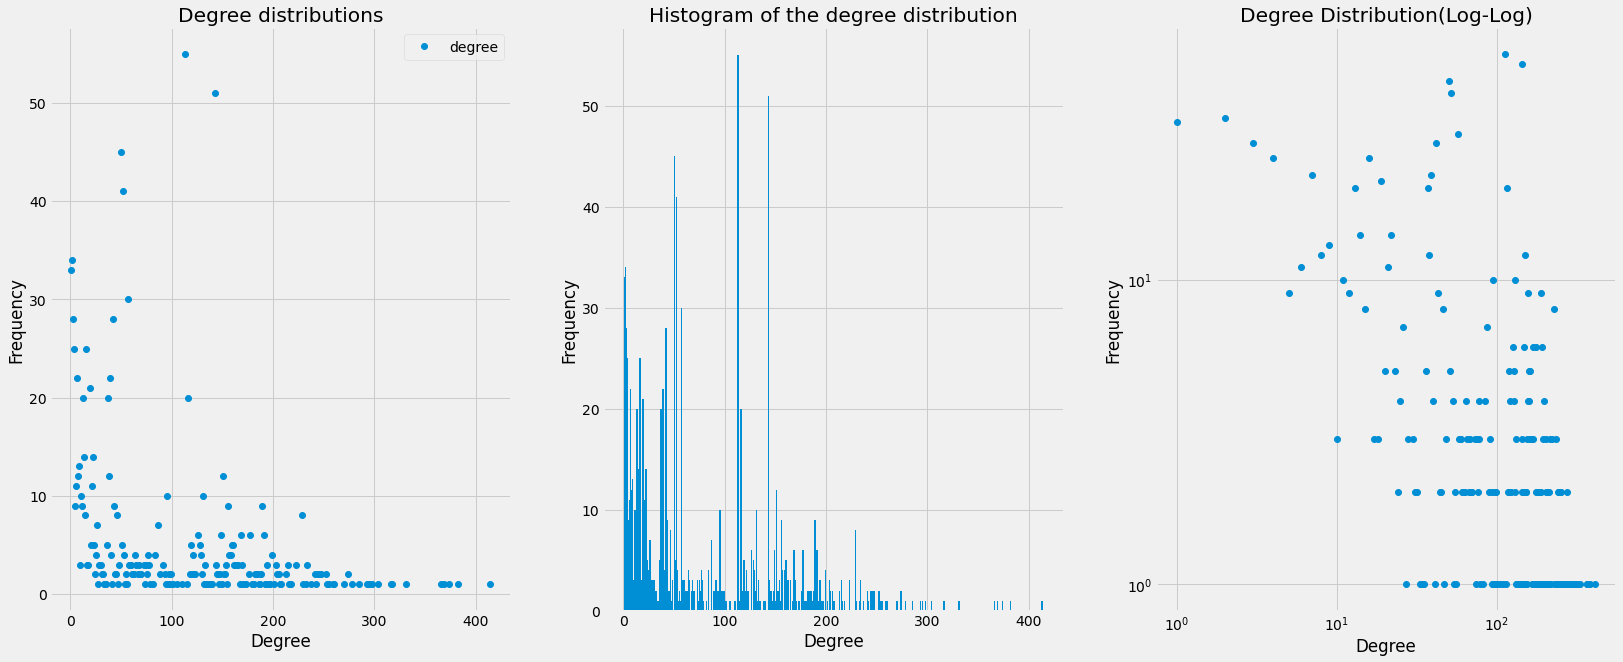

In [ ]:
f = plt.figure(figsize=(25,10))

plt.subplot(1,3,1)
plotDegree(degree_sequence, label='degree')
plt.subplot(1,3,2)
histPlot(degree_sequence)
plt.subplot(1,3,3)
logPlot(degree_sequence)
f.show()

### Power law fit

In [ ]:
fit = powerlaw.Fit(degree_sequence)

print(f"Exponent for in_degree distribution is {fit.power_law.alpha}")

Calculating best minimal value for power law fit
Exponent for in_degree distribution is 6.927815052635757


Looking at the degree distribution and the power law fit it can be seen that the writers award network is a small world network. The hubs are present but are not large enough to significantly decrease the distance between the writers. This network is more characteristic of a random network. This kind of makes sense as well since writers are a huge network with a  lot of famous writers who have been awarded over centuries and the network of writers and books is just too big for a single writer to have a huge affect on this network. There are a lot of writers over different genres that act like medium sized hubs instead. 

### Random Network with same degree distribution

In [ ]:
N = len(DG.nodes)
k = sum(degree_sequence) / N
p = k / (N - 1)

randomG = nx.generators.random_graphs.erdos_renyi_graph(N, p)
random_degree_sequence = sorted([d for n, d in randomG.degree()], reverse=True)

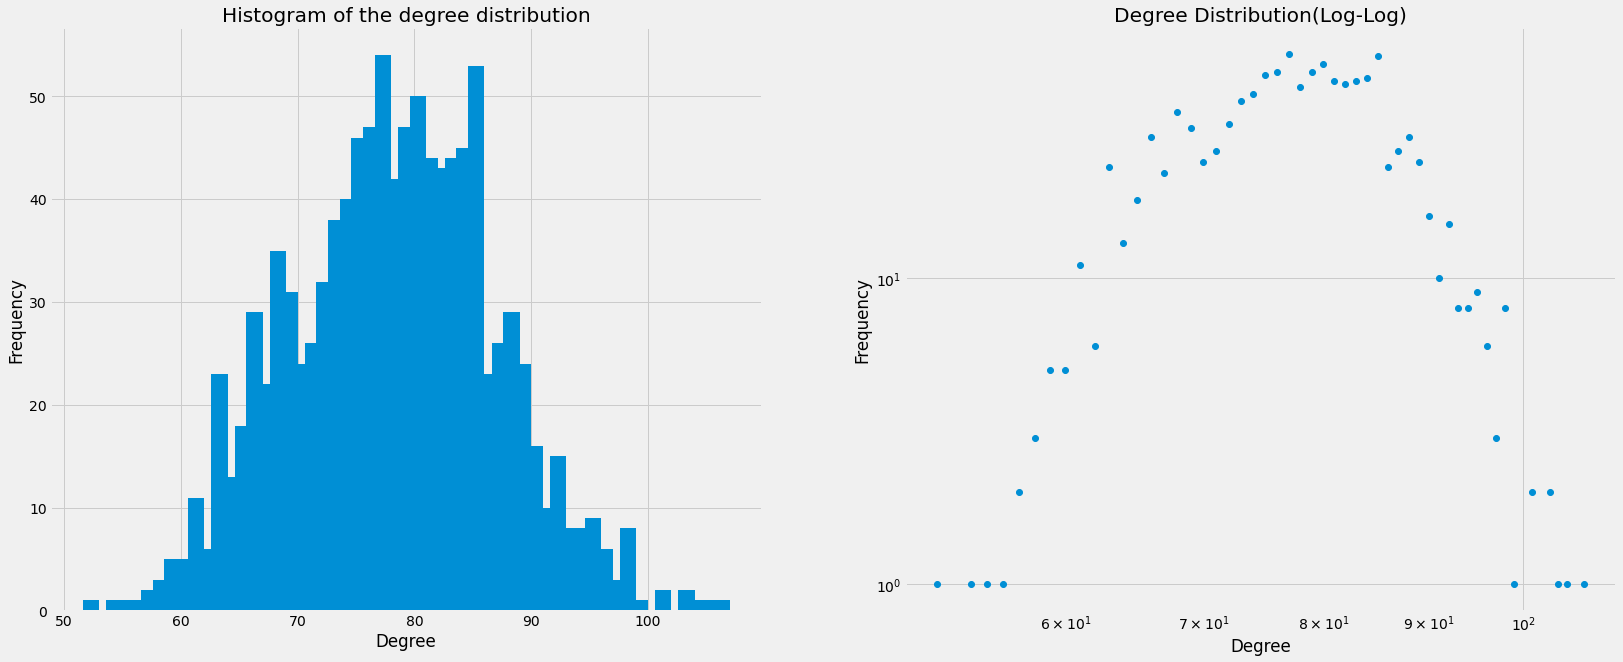

In [ ]:
f = plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
histPlot(random_degree_sequence)
plt.subplot(1,2,2)
logPlot(random_degree_sequence)
f.show()

### Network Visualization

100%|██████████| 2000/2000 [00:26<00:00, 74.58it/s]
BarnesHut Approximation  took  6.10  seconds
Repulsion forces  took  13.23  seconds
Gravitational forces  took  0.12  seconds
Attraction forces  took  5.37  seconds
AdjustSpeedAndApplyForces step  took  0.67  seconds


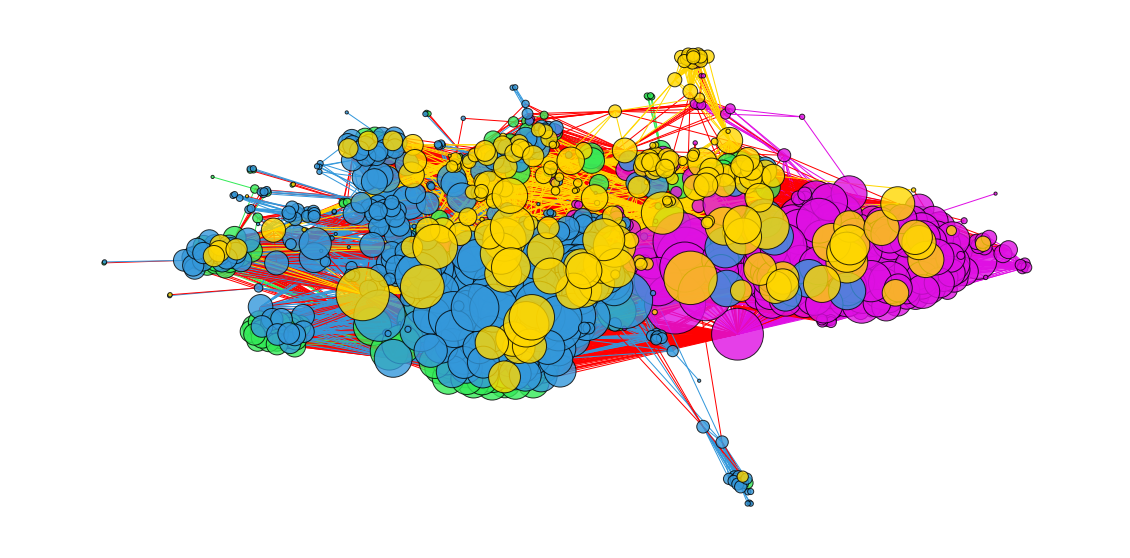

In [22]:
cc = sorted(nx.connected_components(DG), key=len, reverse=True)
gcc = DG.subgraph(cc[0])

d = dict(gcc.degree)

# nx.draw(gcc, nodelist=d.keys(), node_size=[(v+1) * 20 for v in d.values()])
# plt.figure(figsize=(20,10))
# plt.show()
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.5,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=100.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(gcc,  iterations=2000)

list_degree=list(gcc.degree()) #this will return a list of tuples each tuple is(node,deg)
nodes , degree = map(list, zip(*list_degree)) #build a node list and corresponding degree list

#Set node color
color_map = []
for node in gcc.nodes(data=True):
    if 'genre' in node[1].keys():
        if node[1]['genre'] == 'Playwright':
            color_map.append('#34eb58')#Green
        if node[1]['genre'] == 'Poet':
            color_map.append('#3498DB')#blue
        if node[1]['genre'] == 'Fantasy':
            color_map.append('#df10e3')#magenta
        if node[1]['genre'] == 'Historical Novelist':
            color_map.append('#ffd700')#Gold
    else:
        color_map.append('#0000ff')
edgeColor_map =[]
#Set edge color
for edge in gcc.edges():
    source = gcc.nodes[edge[0]]
    target = gcc.nodes[edge[1]]
    if 'genre' in source.keys() and 'genre' in target.keys() :
        if source['genre'] == target['genre']:
            if source['genre'] == 'Playwright' and target['genre'] == 'Playwright':
                edgeColor_map.append("#34eb58")#Green
            if source['genre'] == 'Poet' and target['genre'] == 'Poet':
                edgeColor_map.append("#3498DB")#blue
            if source['genre'] == 'Fantasy' and target['genre'] == 'Fantasy':
                edgeColor_map.append("#df10e3")#magenta
            if source['genre'] == 'Historical Novelist' and target['genre'] == 'Historical Novelist':
                edgeColor_map.append("#ffd700")#Gold
        else:
            edgeColor_map.append('#ff0000')#Red
    else:
        edgeColor_map.append('#0000ff')
        


plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(gcc, positions, nodelist=nodes, node_size=[(v * 9)+1 for v in degree], node_color=color_map,edgecolors="black", alpha=0.8)
nx.draw_networkx_edges(gcc, positions, edge_color=edgeColor_map)
plt.axis('off')

plt.show()

In the visualization above, the playwrights are shown in green, poets in blue, fantasy writers in magenta and historical novelist in gold. Just by looking at the visual representation of this network, we can see that the network doesn't have really large hubs, rather a lot of medium-sized ones. It can also be seen that the poets are more close to the playwrights. The historical novelist seem to be all over the place but if looked at it closely it can be seen that they are more closely associated with the fantasy authors which kinds of make sense as well as the historical novelist also create a fantasy universe with the story setting information coming from the history of humanity. 

## Part 2: Word-clouds

In [24]:
#Create the corpus
corpus_root = 'cleanFiles'
newcorpus = PlaintextCorpusReader(corpus_root, '.*')

# update dataframe - keep only the characters who exist in the largest component
df_gcc = df_authors[df_authors.Name.isin(gcc.nodes())]
df_gcc = df_gcc.reset_index(drop = True)

gcc_filenames=[ re.sub(" ", "_", x) for x in df_gcc.Name]
gcc_name=[ re.sub(" ", "_", x) for x in df_gcc.Name]


Cleaning up the authors wiki files and storing it in a new folder, "cleanFiles". Comment out the code in the cell below if you don't want to see this code in action and just make sure that the "cleanText" folder is in the current directory of the notebook.

In [ ]:


#CLEANING THE TEXT FILES

stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
wnl = nltk.WordNetLemmatizer()
listOfCleanCheckNames = []

more_stopwords = {'writer', '=', 'ha', "ref","</ref>","<ref>","http://","http:","org",".org","http://www" "http", "date","url","www","cite", "title","com", "name","category","wa","archive","web","de", 
"p", "la", "isbn", "book", "http", "sfn","www"}
stop_words = stop_words.union(more_stopwords)

for name in gcc_filenames:
    file1 = open("Authors/" + name + ".txt")
    theText = file1.read()

    # Regex
    theText = re.sub('==.*?==', '', theText)

    # Remove every name from every text file
    for test in gcc_name:
        theText = re.sub(test, '', theText)

    # Removing punctuations
    words = tokenizer.tokenize(theText)

    for r in words:
        #Setting to lowercase
        r = r.lower()
        
        # Lemmatization
        r = wnl.lemmatize(r)
        
        if r not in stop_words:
            appendFile = open("cleanFiles/" + name + ".txt",'a')
            appendFile.write(" "+r)
            appendFile.close()

        
    listOfCleanCheckNames.append(name)

In [25]:
# Create dataframes for each genre
df_Playwright = df_gcc.loc[(df_gcc['genre'] == 'Playwright')]
df_Poet = df_gcc.loc[(df_gcc['genre'] == 'Poet')]
df_Fantasy = df_gcc.loc[(df_gcc['genre'] == 'Fantasy')]
df_history = df_gcc.loc[(df_gcc['genre'] == 'Historical Novelist')]

In [ ]:
# Extract the names from the dataframes for future use
playwrights = [ re.sub(" ", "_", x) for x in df_Playwright.Name.values]
poets = [ re.sub(" ", "_", x) for x in df_Poet.Name.values]
fantasys = [ re.sub(" ", "_", x) for x in df_Fantasy.Name.values]
histories = [ re.sub(" ", "_", x) for x in df_history.Name.values]

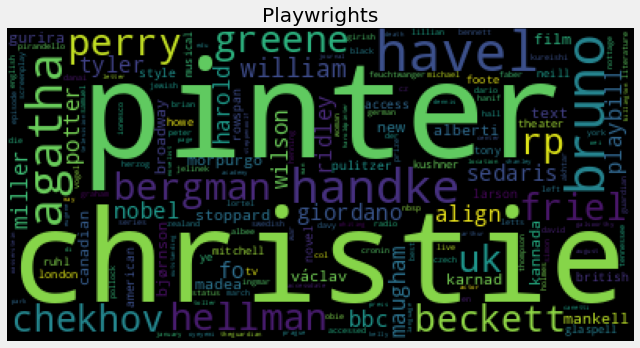

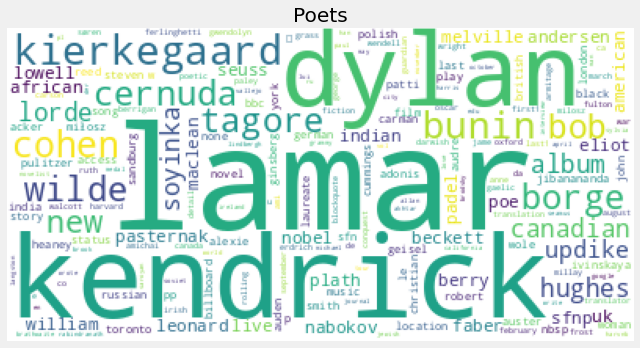

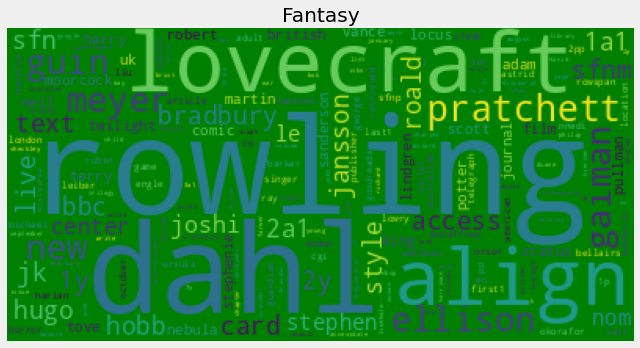

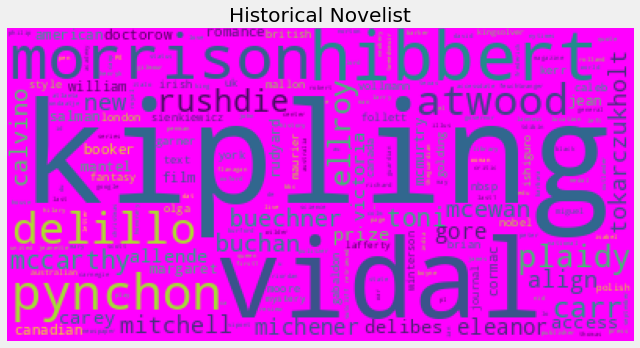

In [ ]:
#Plotting world clouds for all genres

playwrightsCloud = calcRate(playwrights)
historiesCloud = calcRate(histories)
poetsCloud = calcRate(poets)
fantasysCloud = calcRate(fantasys)
plt.figure( figsize=(10,6))
wordcloud = WordCloud(background_color="black", collocations = False).generate(playwrightsCloud)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Playwrights")
plt.show()

plt.figure( figsize=(10,6))
wordcloud = WordCloud(background_color="white", collocations = False).generate(poetsCloud)
img=plt.imshow(wordcloud)
plt.axis("off")
plt.title("Poets")
plt.show()

plt.figure( figsize=(10,6))
wordcloud = WordCloud(background_color="green", collocations = False).generate(fantasysCloud)
img=plt.imshow(wordcloud)
plt.axis("off")
plt.title("Fantasy")
plt.show()

plt.figure( figsize=(10,6))
wordcloud = WordCloud(background_color="magenta", collocations = False).generate(historiesCloud)
img=plt.imshow(wordcloud)
plt.axis("off")
plt.title("Historical Novelist")
plt.show()

 Some of the key observation from the world clouds of all the genres is how they are dominated by the most iconic authors in these categories. For playwrights its Harold Pinter, Agatha Christie, Anton Chekhov. For poets it's interestingly Kendrick Lamar and Bob Dylan who are singer songwriters. For fantasy its JK Rowling and Roald Dahl. For Historical Novelist, it is Rudyard Kipling, Gore Vidal, Salman Rushdie etc. This represents that the writers in these genres are heavily influenced by the most popular writers in their genre. These writers are heavily influenced by other writers in their category and have probably read a lot of their books. From these world clouds, you could also conclude that in order to be a great writer in a particular genre, first you have to read the other authors in that genre and only then you could a create a new masterpiece of your own.

### Communities

In [26]:
def communities(graph):
    louvain_partition = community_louvain.best_partition(graph)
    d = collections.defaultdict(list)

    print(community_louvain.modularity(louvain_partition,graph))
    
    # Mapping the nodes 
    for com in set(louvain_partition.values()):
        for nodes in louvain_partition.keys():
            if louvain_partition[nodes] == com:
                d[com].append(nodes)
    
    return list(d.values())

### Visual representation of the communities

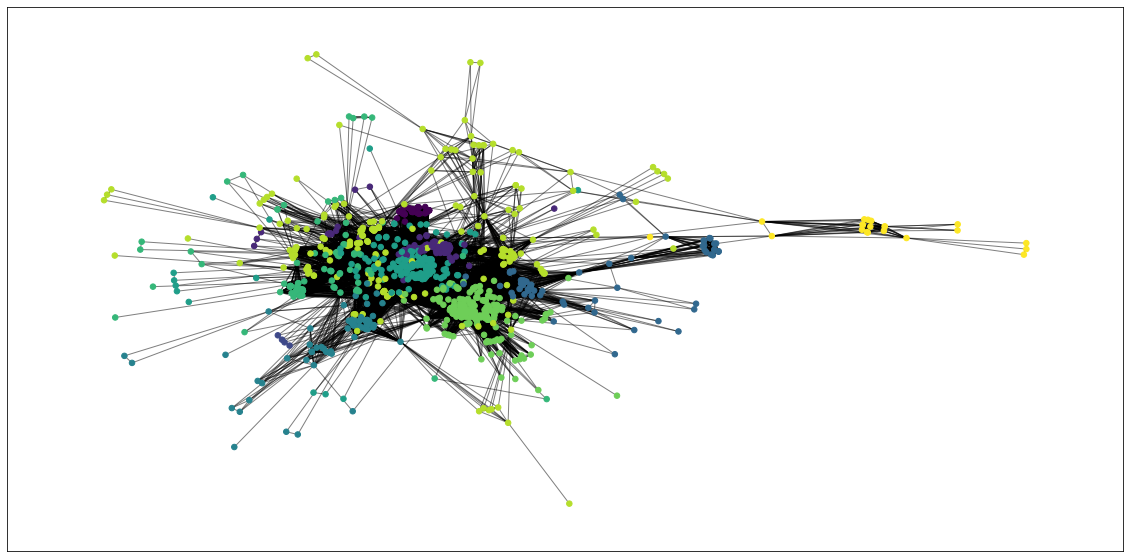

In [27]:


#An undirected graph of characters
G = gcc.to_undirected()

#computing the best partition
partition = community_louvain.best_partition(G)

all_partitions = list(partition.values())

plt.figure(figsize=(20,10))
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=30, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Number of Communities

In [28]:
from collections import Counter

#A list including all communities
allC = dict(Counter(all_partitions))
sorted_c = dict(sorted(allC.items()))

print("Number of communities: ", len(sorted_c.keys()))

Number of communities:  10


### Value of modularity with the partition created by the algorithm:

In [29]:
#The modularity
modularity = community_louvain.modularity(partition, G)

print("The modularity of the community partitioning: ", modularity)

The modularity of the community partitioning:  0.5500294857710003


### Distribution of community sizes

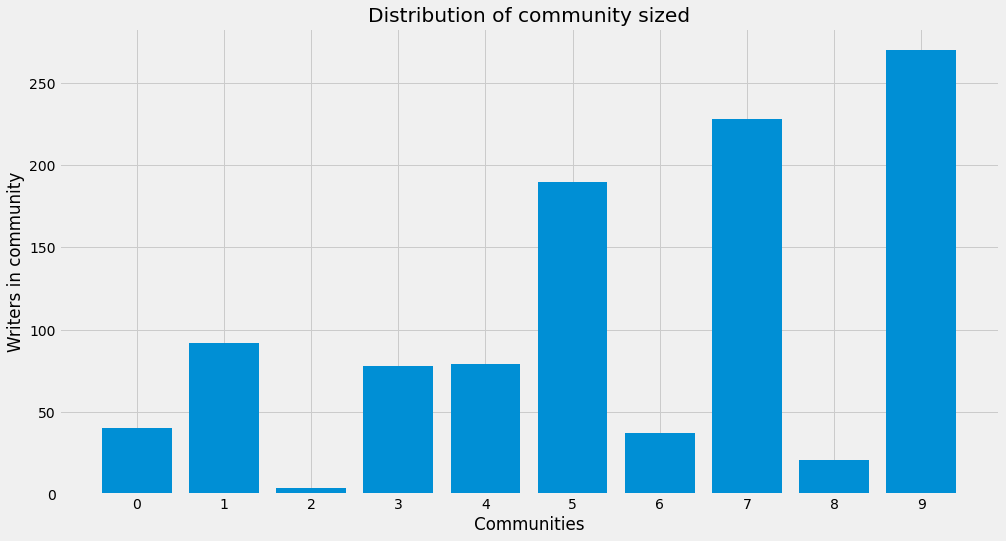

In [ ]:
labels, values = zip(*sorted_c.items())

indexes = np.arange(len(labels))

plt.bar(indexes, values)
plt.xticks(indexes, labels)
plt.ylabel("Writers in community")
plt.xlabel("Communities")
plt.title('Distribution of community sizes')
plt.show()

### Top most communities by number of writers

In [ ]:
#Find most common communities
mostCommonC = Counter(allC).most_common(5)
fiveLargest = []

for i in mostCommonC:
    fiveLargest.append(i[0])

print("The five most common communities: ", fiveLargest)

The five most common communities:  [9, 7, 5, 1, 4]


### Common attributes in these communities 

In [35]:

def calcCommunityFabric(community, namesInCommunity):
    b_country=[]
    d_country=[]
    b_decade=[]
    d_decade=[]
    natio=[]
    awards=""
    awards_number={}
    for name in namesInCommunity:
        if name in gcc_name :
            index= df_gcc[df_gcc["Name"]== name.replace("_"," ")].index.tolist()[0]
            bc= df_gcc["birth country"][index]
            dc = df_gcc["death country"][index]
            bd= df_gcc["birth decade"][index]
            dd= df_gcc["death decade"][index]
            nat= df_gcc["nationality"][index]
            awar= df_gcc["awards"][index]

            if((bc!= '')&(bc != None)):
                b_country.append(bc)
            if((dc!= '')&(dc!= None)):
                d_country.append(bc)
            if((bd!= '')&(bd!= None)):
                b_decade.append(bd)
            if((dd!= '')&(dd!= None)):
                d_decade.append(dd)
            if((nat!= '')&(nat!= None)):
                natio.append(nat)
            if((awar!= '')&(awar!= None)):
                awards= awards + "\t" +awar 

    birth= collections.Counter(b_country)
    death= collections.Counter(d_country)
    birth_decade= collections.Counter(b_decade)
    death_decade= collections.Counter(d_decade)
    nationality= collections.Counter(natio)
    aw_split= collections.Counter(awards.split("\t"))
    aw_split.pop('', None)

    print("Statistics for community number ", community)
    print("Most Common with number of members with attribute - Birth Country:", Counter(birth).most_common(1)[0], ",Birth Decade:", Counter(birth_decade).most_common(1)[0], "Death Decade:", Counter(death_decade).most_common(1)[0],",Nationality:", Counter(nationality).most_common(1)[0])  
    print("Most common award with number of memberrs with award:", Counter(aw_split).most_common(1)[0])
    print("-------------------------------------------------------------")
    print("\n")

In [36]:
communities = defaultdict(list)

#All characters in each community
for key, value in partition.items(): 
    key = key.replace(" ", "_")
    communities[value].append(key)
    
sortedC =dict(sorted(communities.items()))

In [39]:
#Run calcTopFive function for all communities
for key, value in sortedC.items():
    calcCommunityFabric(key, value)

Statistics for community number  0
Most Common with number of members with attribute - Birth Country: ('United States', 4) ,Birth Decade: ('1970', 6) Death Decade: ('1990', 1) ,Nationality: ('United States', 1)
Most common award with number of memberrs with award: ('Whiting Awards', 40)
-------------------------------------------------------------


Statistics for community number  1
Most Common with number of members with attribute - Birth Country: ('United States', 6) ,Birth Decade: ('1930', 13) Death Decade: ('1980', 9) ,Nationality: ('United States', 2)
Most common award with number of memberrs with award: ('Pulitzer Prize', 84)
-------------------------------------------------------------


Statistics for community number  2
Most Common with number of members with attribute - Birth Country: ('United Kingdom', 1) ,Birth Decade: ('1910', 1) Death Decade: ('2010', 1) ,Nationality: ('United Kingdom', 1)
Most common award with number of memberrs with award: ('Michael Braude Award for L

### Major talking points(words) in these communities

In [ ]:
#Function to find top five words  according to TF and TF-IDF

def calcTopFive(community, namesInCommunity):
    wordsInCommunity = defaultdict(list)
    appearsInCorpus = defaultdict(list)

    wordsByTF = defaultdict(list)
    wordsByTFIDF = defaultdict(list)
    documentLength = 0

    for name in namesInCommunity:
        if name in gcc_filenames :

            theText = nltk.Text(newcorpus.words(name + '.txt'))
            fdist = FreqDist(theText)
            documentLength += len(theText)
            
            for word in fdist:
                wordTF = fdist[word]
                    
                wordsInCommunity[word].append(wordTF)
                appearsInCorpus[word].append(name)

    
    for key, value in wordsInCommunity.items():
        TF = sum(value) / documentLength
        IDF = math.log(len(namesInCommunity) / len(appearsInCorpus[key]))
        TFIDF = math.ceil(TF*IDF)

        wordsByTF[key].append(TF)
        wordsByTFIDF[key].append(TFIDF)
 
    topFiveTF = Counter(wordsByTF).most_common(20)
    topFiveTFIDF = Counter(wordsByTFIDF).most_common(20)

    print("The top ten words in community number:", community)
    
    TfList = []
    cnt=0
    for i in topFiveTF:
        if((i[0]!= "http")&(i[0]!= "html")):
            TfList.append(i[0])
            cnt = cnt+1
        if(cnt==10):
            break;
    print("by using TF:\t", TfList)


    cnt=0    
    TfidfList = []
    for i in topFiveTFIDF:
        if((i[0]!= "http")&(i[0]!= "html")):
            TfidfList.append(i[0])
            cnt = cnt+1
        if(cnt==10):
            break;
        
        
    print("by using TF-IDF:", TfidfList)
    print("-------------------------------------------------------------")
    print("\n")

In [ ]:
#Run calcTopFive function for all communities
for key, value in sortedC.items():
    calcTopFive(key, value)
    

The top ten words in community number: 0
by using TF:	 ['award', 'play', 'new', 'theatre', 'american', 'playwright', 'theater', 'york', '2015', 'university']
by using TF-IDF: ['adjmi', 'theatre', 'david', '2009', 'playwright', 'new', '2011', 'play', 'theater', 'american']
-------------------------------------------------------------


The top ten words in community number: 1
by using TF:	 ['new', 'american', 'award', 'play', 'access', 'first', 'york', 'work', 'news', 'year']
by using TF-IDF: ['akhtar', 'access', 'best', '2020', 'website', 'ayad', 'book', '2021', '02', '10']
-------------------------------------------------------------


The top ten words in community number: 2
by using TF:	 ['conquest', 'robert', 'soviet', 'poet', 'brown', 'british', '2015', 'book', 'access', 'great']
by using TF-IDF: ['conquest', 'soviet', 'robert', 'brown', '2015', 'great', 'historian', 'terror', 'access', 'law']
-------------------------------------------------------------


The top ten words in com

# Sentiment Analysis

In [ ]:
from nltk.stem import WordNetLemmatizer 

lemmatizer = WordNetLemmatizer()

def preppData(CharacterText):
    preppedText = []

    for sentance in CharacterText:
        #tokenize and to lowercase
        tokenizedSentance = nltk.word_tokenize(sentance.lower())
        for token in tokenizedSentance:
            #lemmatize words
            preppedText.append(lemmatizer.lemmatize(token))

    return preppedText

In [ ]:
#LABMT Calculations

data = pd.read_csv('Data_Set_S1.txt', sep="\t", header=None)
data.columns = ["word", "happiness_rank", "happiness_average", "happiness_standard_deviation", "twitter_rank", "google_rank", "nyt_rank", "lyrics_rank"]
sentimentData = data[["word", "happiness_average"]]

def sentimentScore(preppedCharData):
    scores = []

    for token in preppedCharData:
        wordRow = sentimentData[sentimentData.isin([token]).any(axis=1)]

        if not wordRow.empty:
            scores.append(wordRow.iloc[0]["happiness_average"])

    scoreLen = len(scores)
    scoreSum = sum(scores)
    scoreAvg = scoreSum /scoreLen

    return scoreAvg

In [ ]:
#VADER Calculations

analyzer = SentimentIntensityAnalyzer()

#A function for calculating  Vader sentiment scores
def vaderSentimentScores(preppedCharData):
    scores = []
    for sentence in preppedCharData:

        vs = analyzer.polarity_scores(sentence)
        scores.append(vs['compound'])

    scoreLen = len(scores)
    scoreSum = sum(scores)
    scoreAvg = scoreSum /scoreLen

    return scoreAvg

In [ ]:
#calculate the average sentiment of every character

charSentScores = {}
vaderSentScores = {}

for key,name in enumerate(gcc_filenames):
    theText = nltk.Text(newcorpus.words(name + '.txt'))
    #prepare data
    preppedCharData = preppData(theText)
    #calculate scores
    sentScore = sentimentScore(preppedCharData)
    charSentScores[name] = sentScore
    #vader scores
    sentScoreVader = vaderSentimentScores(theText)
    vaderSentScores[name] = sentScoreVader

print("All scores have been successfully calculated!")

All scores have been successfully calculated!


### LABMT Sentiment Analysis Results for writers

(array([  1.,   2.,   0.,   5.,   6.,  22.,  28.,  57.,  86., 128., 157.,
        160., 141., 109.,  65.,  38.,  21.,   7.,   4.,   2.]),
 array([5.33467672, 5.3826212 , 5.43056569, 5.47851017, 5.52645466,
        5.57439915, 5.62234363, 5.67028812, 5.7182326 , 5.76617709,
        5.81412157, 5.86206606, 5.91001055, 5.95795503, 6.00589952,
        6.053844  , 6.10178849, 6.14973298, 6.19767746, 6.24562195,
        6.29356643]),
 <BarContainer object of 20 artists>)

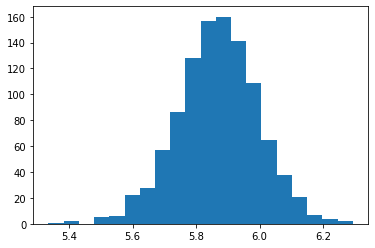

(array([  2.,   1.,   1.,   5.,  10.,  28.,  37.,  62., 116., 134., 160.,
        161., 122.,  88.,  59.,  30.,  12.,   7.,   2.,   2.]),
 array([5.34552477, 5.39315032, 5.44077586, 5.48840141, 5.53602696,
        5.58365251, 5.63127805, 5.6789036 , 5.72652915, 5.77415469,
        5.82178024, 5.86940579, 5.91703134, 5.96465688, 6.01228243,
        6.05990798, 6.10753353, 6.15515907, 6.20278462, 6.25041017,
        6.29803571]),
 <BarContainer object of 20 artists>)

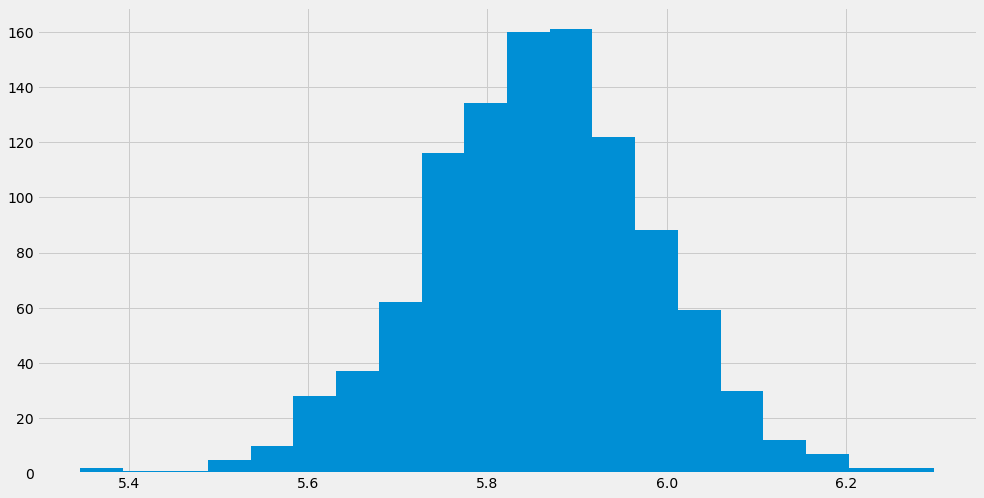

In [ ]:
# Histogram using the LabMT sentiment scores

LabMTValues = []  

for key, value in charSentScores.items():
    LabMTValues.append(value)

plt.hist(LabMTValues, bins=20)

### VADER Sentiment Analysis for writers

(array([  1.,   1.,  11.,  48., 153., 267., 217., 153., 106.,  39.,  25.,
          8.,   5.,   2.,   1.,   0.,   1.,   0.,   0.,   1.]),
 array([-0.0213128 , -0.01569803, -0.01008325, -0.00446847,  0.00114631,
         0.00676108,  0.01237586,  0.01799064,  0.02360542,  0.0292202 ,
         0.03483497,  0.04044975,  0.04606453,  0.05167931,  0.05729408,
         0.06290886,  0.06852364,  0.07413842,  0.0797532 ,  0.08536797,
         0.09098275]),
 <BarContainer object of 20 artists>)

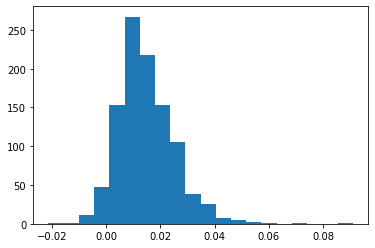

(array([  1.,   1.,  11.,  44., 141., 265., 220., 156., 108.,  42.,  32.,
          7.,   5.,   2.,   2.,   0.,   1.,   0.,   0.,   1.]),
 array([-0.02179391, -0.01612841, -0.01046291, -0.00479741,  0.00086809,
         0.00653359,  0.01219908,  0.01786458,  0.02353008,  0.02919558,
         0.03486108,  0.04052658,  0.04619207,  0.05185757,  0.05752307,
         0.06318857,  0.06885407,  0.07451957,  0.08018506,  0.08585056,
         0.09151606]),
 <BarContainer object of 20 artists>)

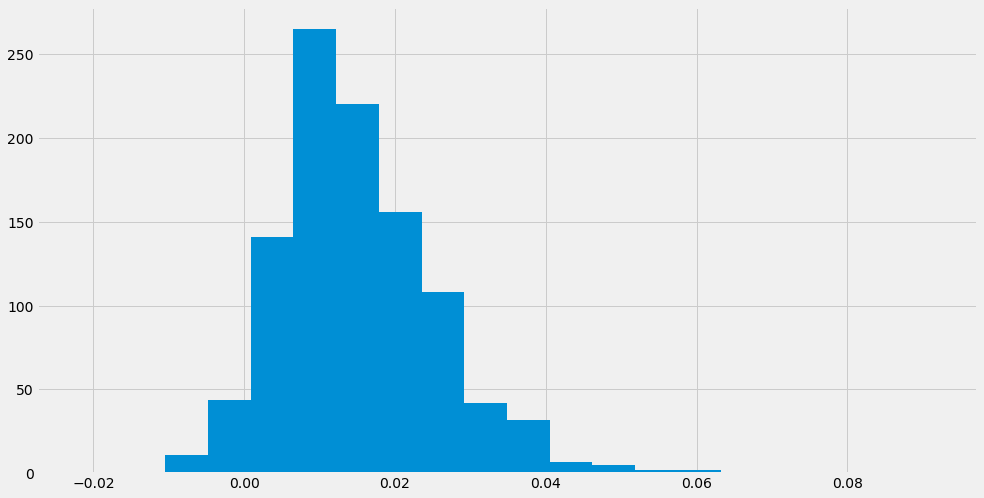

In [ ]:
# Histogram using the Vader sentiment scores

vaderValues = []

for key, value in vaderSentScores.items():
    vaderValues.append(value)

plt.hist(vaderValues, bins=20)

### Happiest and Saddest Writers

In [ ]:
#LabMT
sortedScores = sorted(charSentScores.items(), key=lambda x: x[1])

print("10 happiest writers by using LabMT: ")
LSort = []

for i in sortedScores[0:10]:
    LSort.append(i[0])

print(LSort)

print("10 saddest writers by using LabMT: ")

LSortSad = []

for i in sortedScores[-10:]:
    LSortSad.append(i[0])

print(LSortSad)
print("-------------------------------------")

#Vader
sortedVaderScores = sorted(vaderSentScores.items(), key=lambda x: x[1])

print("10 happiest writers by using Vader: ")
VSort = []

for i in sortedVaderScores[0:10]:
    VSort.append(i[0])

print(VSort)

print("10 saddest writers by using Vader: ")
VSortSad = []

for i in sortedVaderScores[-10:]:
    VSortSad.append(i[0])

print(VSortSad)

10 happiest writers by using LabMT: 
['Gilles_Vigneault', 'Martin_Walser', 'John_Dickson_Carr', 'Karen_Maitland', 'Franz_Fühmann', 'Sidney_Keyes', 'Erich_Kästner', 'Nelly_Sachs', 'Charlaine_Harris', 'Dario_Fo']
10 saddest writers by using LabMT: 
['Helen_Lowe', 'Nancy_Farmer_(author)', 'Selima_Hill', 'Mary_Robinette_Kowal', 'Helene_Wecker', 'Marita_Conlon-McKenna', 'Seanan_McGuire', 'Carol_Berg', 'Jill_Marie_Landis', 'Zen_Cho']
-------------------------------------
10 happiest writers by using Vader: 
['Karen_Maitland', 'Sidney_Keyes', 'Erich_Kästner', 'Charlaine_Harris', 'John_Dickson_Carr', 'Anne_Perry', 'Reetika_Vazirani', 'Caleb_Carr', 'Michael_Kurland', 'Anis_Mojgani']
10 saddest writers by using Vader: 
['Helene_Wecker', 'Zen_Cho', 'Jun_Lana', 'Sebastien_de_Castell', 'Karen_Joy_Fowler', 'Lynn_Kurland', 'Mary_Robinette_Kowal', 'Jodi_Thomas', 'Seanan_McGuire', 'Jill_Marie_Landis']


10 happiest writers by using LabMT: 
['Gilles_Vigneault', 'Martin_Walser', 'John_Dickson_Carr', 'Karen_Maitland', 'Sidney_Keyes', 'Franz_Fühmann', 'Erich_Kästner', 'Charlaine_Harris', 'Nelly_Sachs', 'Daniel_Berrigan']
10 saddest writers by using LabMT: 
['Nancy_Farmer_(author)', 'Jordan_Ifueko', 'James_Stoddard_(author)', 'Marita_Conlon-McKenna', 'Mary_Robinette_Kowal', 'Helene_Wecker', 'Seanan_McGuire', 'Carol_Berg', 'Jill_Marie_Landis', 'Zen_Cho']
-------------------------------------
10 happiest writers by using Vader: 
['Karen_Maitland', 'Sidney_Keyes', 'Erich_Kästner', 'Charlaine_Harris', 'John_Dickson_Carr', 'Anne_Perry', 'Reetika_Vazirani', 'Caleb_Carr', 'Michael_Kurland', 'Anis_Mojgani']
10 saddest writers by using Vader: 
['Helene_Wecker', 'Zen_Cho', 'Jun_Lana', 'Karen_Joy_Fowler', 'Sebastien_de_Castell', 'Lynn_Kurland', 'Mary_Robinette_Kowal', 'Jodi_Thomas', 'Seanan_McGuire', 'Jill_Marie_Landis']


### Community Sentiment Analysis

In [ ]:
#All communities by numeration
communities = defaultdict(list)

for key, value in partition.items(): 
    communities[value].append(key)

In [ ]:
#Community sentiment scores using LabMT

LabMTCommunityScores = {}

for key, value in communities.items():
    #LabM
    charScoresLabmt = []

    for character in value:
        sentScore =  charSentScores[character.replace(" ", "_")]
        charScoresLabmt.append(sentScore)
    LabmTscoreLen = len(charScoresLabmt)
    LabmTscoreSum = sum(charScoresLabmt)
    if LabmTscoreLen != 0:
        LabmTscoreAvg = LabmTscoreSum /LabmTscoreLen
        LabMTCommunityScores[key] = LabmTscoreAvg

print("The community sentiment scores using LabMT have been successfuly computed!")

The community centiment scores using LabMT have been successfuly computed!


The community centiment scores using LabMT have been successfuly computed!


In [ ]:
#Community sentiment scores using Vader

vaderCommunityScores = {}
charScoresVader = []
for key, value in communities.items():
    for character in value:
        charScoresVader.append(vaderSentScores[character.replace(" ", "_")])

    vaderScoreLen = len(charScoresVader)
    vaderScoreSum = sum(charScoresVader)
    vaderScoreAvg = vaderScoreSum /vaderScoreLen

    vaderCommunityScores[key] = vaderScoreAvg

print("The community sentiment scores using Vader have been successfuly computed!")

The community centiment scores using Vader have been successfuly computed!


The community centiment scores using Vader have been successfuly computed!


### Happiest and Saddest Communities

In [ ]:
#LabMT
sortedLabMTCommunityScores = sorted(LabMTCommunityScores.items(), key=lambda x: x[1])

print("3 happiest communities by using LabMT: ", sortedLabMTCommunityScores[0:3])

print("-------------------------------------")

#Vader
sortedVaderCommunityScores = sorted(vaderCommunityScores.items(), key=lambda x: x[1])

print("3 happiest communities by using Vader: ", sortedVaderCommunityScores[0:3])

3 happiest communities by using LabMT:  [(4, 5.776547912012418), (8, 5.799462337565516), (3, 5.84297259478736)]
-------------------------------------
3 happiest communities by using Vader:  [(6, 0.014229915516467764), (5, 0.014263334891930308), (4, 0.014683325272676942)]


3 happiest communities by using LabMT:  [(2, 5.7869740862680095), (4, 5.794086147224206), (3, 5.830869962153072)]
-------------------------------------
3 happiest communities by using Vader:  [(6, 0.014490653973133432), (5, 0.014525059269958845), (4, 0.015085572101478727)]


In [ ]:
#LabMT

print("3 saddest communities by using LabMT: ", sortedLabMTCommunityScores[-3:])

print("-------------------------------------")

#Vader

print("3 saddest communities by using Vader: ", sortedVaderCommunityScores[-3:])

3 saddest communities by using LabMT:  [(6, 5.886011487644938), (9, 5.898249651197535), (0, 5.921277108016257)]
-------------------------------------
3 saddest communities by using Vader:  [(3, 0.01556279554120064), (1, 0.015727821973238083), (0, 0.018039213972281358)]


3 saddest communities by using LabMT:  [(6, 5.872211103970247), (8, 5.888606781408537), (0, 5.913688848551525)]
-------------------------------------
3 saddest communities by using Vader:  [(3, 0.015923377904162952), (1, 0.016807971479198505), (0, 0.01837770600259713)]


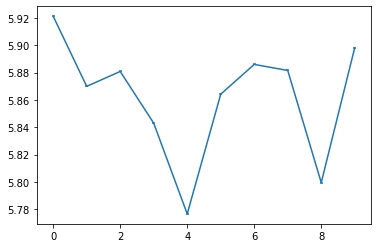

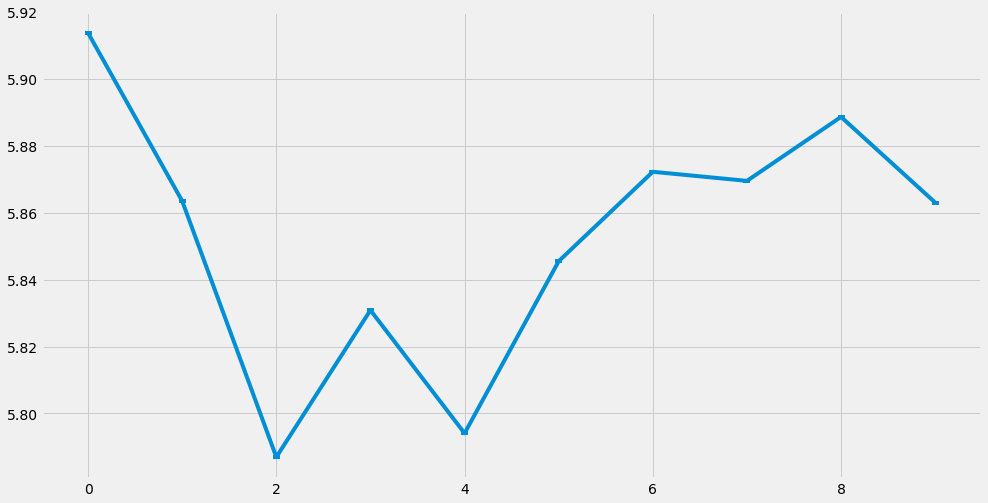

In [ ]:
#Bar plot using LabMT

sortedLabMTCommunityScores = collections.OrderedDict(sorted(LabMTCommunityScores.items()))

commVader = []
x = []
for key, value in sortedLabMTCommunityScores.items():
    commVader.append(value)
    x.append(key)

vaderStddev = np.std(commVader)
plt.errorbar(x, commVader, xerr = vaderStddev)
plt.show()

OrderedDict([(0, 0.018039213972281358), (1, 0.015727821973238083), (2, 0.015403573391243213), (3, 0.01556279554120064), (4, 0.014683325272676942), (5, 0.014263334891930308), (6, 0.014229915516467764), (7, 0.014933185344448464), (8, 0.014851375336009177), (9, 0.014865365503955928)])


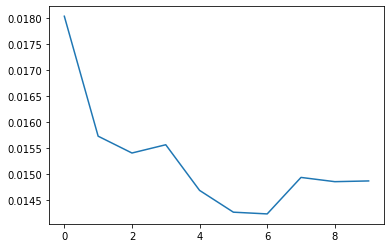

OrderedDict([(0, 0.01837770600259713), (1, 0.016807971479198505), (2, 0.015122607728592896), (3, 0.015923377904162952), (4, 0.015085572101478727), (5, 0.014525059269958845), (6, 0.014490653973133432), (7, 0.015207596430327205), (8, 0.015137202666039276), (9, 0.015767944787239505)])


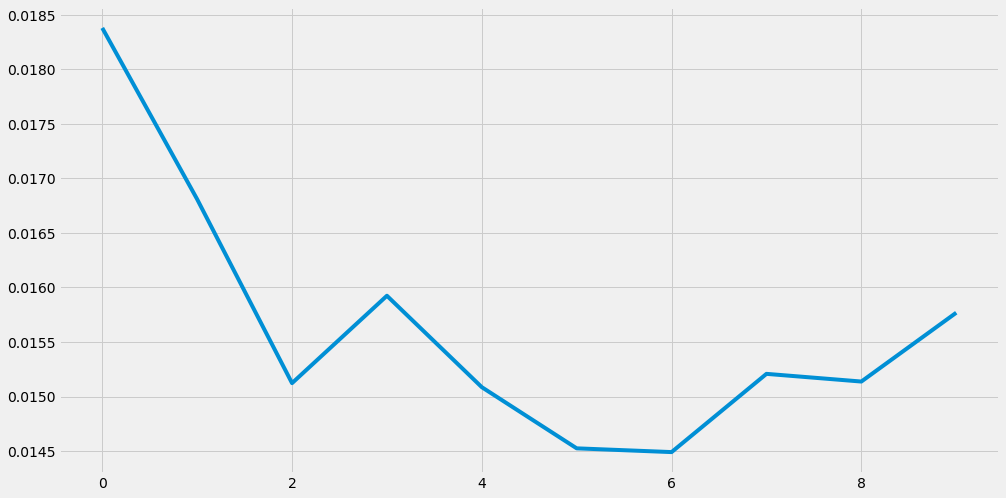

In [ ]:
#Bar plot using Vader

sortedVaderScores = collections.OrderedDict(sorted(vaderCommunityScores.items()))
print(sortedVaderScores)


commVader = []
x = []
for key, value in sortedVaderScores.items():
    commVader.append(value)
    x.append(key)

vaderStddev = np.std(commVader)
plt.errorbar(x, commVader, xerr = vaderStddev)
plt.show()